In [1]:
import os
import sys
import math
from ipywidgets import FloatProgress
from IPython.display import display
from numba import jit
import numpy as np #alloys numpy arrays to be used
import matplotlib as mpl #see next comment
import matplotlib.pyplot as plt #allows use of plt. to plot figures
import pandas as pd
import networkx as nx #https://networkx.readthedocs.io/en/stable/index.html  #Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008
from time import time
sys.path.append("/home/pg1g15/Documents/SEM_Container")
import SEM
from NXFunc import * #imports all my functions from MergerTreeGraphs 
h = SEM.Cosmo.Returnh()

Resolution cut, Scale factor cut, file headers, and input data 

In [2]:
Resolution = np.log10(h) + 11
SF = 0.143
Header = ["scale", "id", "desc_scale", "desc_id", "num_prog", "pid", "upid", "desc_pid", "phantom", "sam_mvir", "mvir", "rvir", "rs", "vrms", "mmp", "scale_of_last_MM", "vmax", "x", "y", "z", "vx", "vy", "vz", "Jx", "Jy", "Jz", "Spin", "Breadth_first_ID", "Depth_first_ID", "Tree_root_ID", "Orig_halo_ID", "Snap_num", "Next_coprogenitor_depthfirst_ID", "Last_progenitor_depthfirst_ID", "Last_mainleaf_depthfirst_ID", "Tidal_Force", "Tidal_ID", "Rs_Klypin", "Mvir_all", "M200b", "M200c", "M500c", "M2500c", "Xoff", "Voff", "Spin_Bullock", "b_to_a", "c_to_a", "Ax", "Ay", "Az", "b_to_a500c", "c_to_a500c", "Ax500c", "Ay500c", "Az500c", "T/|U|", "M_pe_Behroozi", "M_pe_Diemer" ]
BolshoiFiles = os.listdir("/data/B-P50Mpc/Original_Data/")
#BolshoiFiles = ['tree_1_0_0.dat']
print(BolshoiFiles)
Destination = "/home/pg1g15/Documents/SEM_Container/Merger_Trees/Mpc_100_Res11/"
BadTrees = []

['tree_1_0_1.dat', 'tree_0_1_1.dat', 'tree_1_0_0.dat', 'tree_1_1_1.dat', 'tree_0_1_0.dat', 'tree_0_0_1.dat', 'tree_0_0_0.dat', 'tree_1_1_0.dat']


1:Takes the raw bolshoi boxes.

2:Creates individual tree files.

3:Perfoms a mass cut. 

4:Numbers the files into size order.

In [3]:
#processes boxs into individual trees spltting them into files names by their tree ID given by bolshoi 
for Box in BolshoiFiles:
    outfile = open("/data/B-P50Mpc/Header.dat", 'w')
    with open("/data/B-P50Mpc/Original_Data/%s" %(Box)) as infile:
        for line in infile:
            linestr = str.split(line)
            if linestr[0] == '#tree':
                outfile.close()
                Treenum = linestr[1]
                outfile = open("/data/B-P50Mpc/Processed/Tree%s.dat" %(Treenum), 'w')
            else:
                outfile.write(str(line))

In [4]:
#Gets the files that were just split up                
TreeFiles = os.listdir("/data/B-P50Mpc/Processed/")
f = FloatProgress(min = 0, max = len(TreeFiles))
display(f)

#does a resolution cut on the z=0 Halos
RemoveList = []
KeepList = []
for Tree in TreeFiles:
    f.value += 1
    with open("/data/B-P50Mpc/Processed/%s" %(Tree), "r") as File:
        for line in File:
            line = str.split(line)
            Test = line
            if(float(line[40]) > 10.0**Resolution):
                KeepList.append([Tree, float(line[40])])
                break
            else:
                RemoveList.append([Tree, float(line[40])])
                break

#prints the length of the list we intend to keep
print(len(KeepList))

#orders the files and numbers them by size (smallest first)
SortedKeepList = sorted(KeepList, key=lambda x : x[1])
for i, File in enumerate(SortedKeepList):
    print((i/len(KeepList))*100, end = "\r")
    os.system("cp /data/B-P50Mpc/Processed/%s /data/B-P50Mpc/Above12/Tree%s.dat" %(File[0], i) )

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


47720


In [5]:
Files = os.listdir("/data/B-P50Mpc/Above12")
Files.remove('RedshiftCut')
Files.remove('.ipynb_checkpoints')
f = FloatProgress(min = 0, max = len(Files))
display(f)

Trigger = False

for File in Files:
    f.value += 1
    #Files.append(File)
    df = pd.read_csv("/data/B-P50Mpc/Above12/%s" %(File), delim_whitespace = True, names = Header)
    df.M200c = np.log10(df.M200c) #turns m200c into a log10 m200c
    MPH = df.id[0] #identifys the id of the MP
    
    if df.M200c[0] > 14:
        Trigger = True
        print("Beep1")
        print(File)
    else:
        Trigger = False
        
    #Redshift Cut the DF
    DF = df[df.scale > SF]
    #Create network from DF  add more node attributes here for more detailed tree information
    MergerTree = nx.from_pandas_dataframe(DF.drop(0), "id", "desc_id", edge_attr = "mmp", create_using = nx.Graph())
    nx.set_node_attributes(MergerTree, 'scale', pd.Series(DF.scale.values, index=DF.id).to_dict())
    nx.set_node_attributes(MergerTree, 'M200c', pd.Series(DF.M200c.values, index=DF.id).to_dict())
    nx.set_node_attributes(MergerTree, 'mmp', pd.Series(DF.mmp.values, index=DF.id).to_dict())
    nx.set_node_attributes(MergerTree, 'upid', pd.Series(DF.upid.values, index=DF.id).to_dict())
    nx.set_node_attributes(MergerTree, 'pid', pd.Series(DF.pid.values, index=DF.id).to_dict())
    nx.set_node_attributes(MergerTree, 'rvir', pd.Series(DF.rvir.values, index=DF.id).to_dict())
    nx.set_node_attributes(MergerTree, 'rs', pd.Series(DF.rs.values, index=DF.id).to_dict())
    nx.set_node_attributes(MergerTree, 'vmax', pd.Series(DF.vmax.values, index=DF.id).to_dict())
    
    if Trigger:
        print(MergerTree.node[MPH]['M200c'])
    
    #gets the Main prog branch
    MPB = DefineMPB(MergerTree, MPH, MPB = [MPH])
    if 0.2 < MergerTree.node[MPB[-1]]['scale']:
        BadTrees.append(int(File[4:-4]))
        #print(File)
        #print(len(MPB))
        #print(MergerTree.node[MPB[-1]]['scale'])
        #print(df.M200c[0])
        continue
    
    #defines subhalos
    DefineSubHalos(MergerTree, MPH)
    
    #Removes the doubble count
    #RemoveDCM(MergerTree, MPH, MPB, 0, Doubble_Count= [])
    
    #Gets infall halos
    TreeList = MakeSEMTree(MergerTree, MPH, MPB, 0, MaxDepth = len(MPB))
    
    #print("{}Beep4".format(File), end = ("\r"))
    #Creates the output file
    Outfile = open("/data/B-P50Mpc/Above12/RedshiftCut/SEMunbinned/%s" %(File), "w")
    Outfile.write("START\n")
    
    #writes to the output file
    for Epoch in TreeList:
        MainProg = True
        for i in Epoch:
            if MainProg:
                #print(i)
                Outfile.write("mpro " + str(MergerTree.node[i]['scale']) +" "+ str(MergerTree.node[i]['M200c']) +" "+ str(MergerTree.node[i]['rvir']) +" "+ str(MergerTree.node[i]['rs']) +" "+ str(MergerTree.node[i]['vmax']) + "\n")
                MainProg = False
            else:
                Outfile.write( "sat " + str(MergerTree.node[i]['scale']) +" "+ str(MergerTree.node[i]['M200c']) +" "+ str(MergerTree.node[i]['rvir']) +" "+ str(MergerTree.node[i]['rs']) +" "+ str(MergerTree.node[i]['vmax']) + "\n")

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


/home/pg1g15/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


Beep1
Tree47698.dat
14.0005642162
Beep1
Tree47716.dat
14.292898175
Beep1
Tree47719.dat
14.5422027824
Beep1
Tree47714.dat
14.2011512277
Beep1
Tree47704.dat
14.0492567972
Beep1
Tree47715.dat
14.2019703423
Beep1
Tree47707.dat
14.0710346751
Beep1
Tree47705.dat
14.0524245881
Beep1
Tree47702.dat
14.0488688957
Beep1
Tree47710.dat
14.1531743794
Beep1
Tree47708.dat
14.1100844229
Beep1
Tree47700.dat
14.0270232546
Beep1
Tree47717.dat
14.3805187581
Beep1
Tree47703.dat
14.0491792446
Beep1
Tree47718.dat
14.506694403
Beep1
Tree47709.dat
14.1144775399
Beep1
Tree47701.dat
14.0423392046
Beep1
Tree47713.dat
14.1993162743
Beep1
Tree47706.dat
14.0544981466
Beep1
Tree47699.dat
14.01300585
Beep1
Tree47711.dat
14.1836114492
Beep1
Tree47712.dat
14.1905557923


In [6]:
len(BadTrees)

1647

In [7]:
SaveFile = Destination
StartTime = time()
TimeStep = 0
RedshiftStep = 0
MassAtLastWrite = 0
ResolvedMass = -300
Resolution = 8 #logmstar
Switch = True
Exception = False
TreeFiles = os.listdir("/data/B-P50Mpc/Above12/RedshiftCut/SEMunbinned/")
f = FloatProgress(min = 0, max = len(TreeFiles))
display(f)
for File in TreeFiles:
    Switch = True
    RedshiftStep = 0
    MassAtLastWrite = 0
    ResolvedMass = -300
    f.value += 1
    with open("/data/B-P50Mpc/Above12/RedshiftCut/SEMunbinned/%s" %(File), "r") as InputFile, open((SaveFile + "%s" %(File)), "w") as OutputFile:
        for LineStr in InputFile:
            Line = str.split(LineStr) 
            if Line[0] == "START":
                OutputFile.write("START\n")
            else:
                Line[1] = float(Line[1])
                Line[1] = (1 / Line[1]) - 1
                L1asT = SEM.RedshiftToTime(Line[1])
                Line[2] = float(Line[2])

                if Line[0] == "mpro":
                    if Switch == True:
                        if Line[2] == -np.inf:
                            print("-inf", File)
                            BadTrees.append(int(File[4:-4]))
                        OutputFile.write( "mpro  %s  %s  %s  %s\n" %(Line[1], Line[2], Line[3], Line[4]) )
                        MassAtLastWrite = Line[2]
                        Switch = False
                    elif L1asT >= (TimeStep + 0.1):
                        if 10**MassAtLastWrite - 10**Line[2] - 10**ResolvedMass > 0:                            
                            OutputFile.write( "1  acc  %s  %s  %s  1\n" %(Line[1], math.log10(10**MassAtLastWrite - 10**Line[2] - 10**ResolvedMass), Line[5]) ) 
                        else:
                            OutputFile.write( "1  acc  %s  %s  %s  -1\n" %(Line[1], math.log10(abs(10**MassAtLastWrite - 10**Line[2] - 10**ResolvedMass)), Line[5]) ) 
                        MassAtLastWrite = Line[2]
                        ResolvedMass = 0
                        try:
                            if Line[2] == -np.inf:
                                print("-inf", File)
                                BadTrees.append(int(File[4:-4]))
                            OutputFile.write( "mpro  %s  %s  %s  %s  %s\n" %(Line[1], Line[2], Line[3], Line[4], Line[5]) )
                        except:
                            print(File)
                            BadTrees.append(int(File[4:-4]))
                            Exception = True
                            break
                        RedshiftStep += 0.01
                elif Line[0] == "sat" and Line[2] > Resolution:
                    ResolvedMass = math.log10(10**ResolvedMass + 10**Line[2])
                    OutputFile.write( "1  %s  %s  %s  %s  %s\n" %(Line[1], Line[2], Line[3], Line[4], Line[5]) )
    if(Exception == True):
        Exception = False
        continue
print(BadTrees)
np.savetxt(SaveFile + "BadTrees.txt", np.array(list(set(BadTrees))).astype(int))

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


-inf Tree25938.dat
-inf Tree3646.dat
-inf Tree9729.dat
-inf Tree39074.dat
-inf Tree9901.dat
-inf Tree2514.dat
-inf Tree7279.dat
-inf Tree23512.dat
-inf Tree15906.dat
-inf Tree1348.dat
-inf Tree19971.dat
-inf Tree19971.dat
-inf Tree6767.dat
-inf Tree21723.dat
-inf Tree1918.dat
-inf Tree4067.dat
-inf Tree4067.dat
-inf Tree10180.dat
-inf Tree32646.dat
-inf Tree2532.dat
-inf Tree30463.dat
-inf Tree26697.dat
-inf Tree5732.dat
-inf Tree1407.dat
-inf Tree1407.dat
-inf Tree14713.dat
-inf Tree17292.dat
-inf Tree17292.dat
-inf Tree7735.dat
-inf Tree31372.dat
-inf Tree31372.dat
-inf Tree31372.dat
-inf Tree31372.dat
-inf Tree2973.dat
-inf Tree2973.dat
-inf Tree34887.dat
-inf Tree26055.dat
-inf Tree18042.dat
-inf Tree17546.dat
-inf Tree29306.dat
-inf Tree25546.dat
-inf Tree1204.dat
-inf Tree19848.dat
-inf Tree2530.dat
-inf Tree26146.dat
-inf Tree9669.dat
-inf Tree29023.dat
-inf Tree8223.dat
-inf Tree8223.dat
-inf Tree8223.dat
-inf Tree18087.dat
-inf Tree24319.dat
-inf Tree36779.dat
-inf Tree3606.da

-inf Tree41733.dat
-inf Tree8495.dat
-inf Tree33115.dat
-inf Tree11140.dat
-inf Tree10881.dat
-inf Tree3761.dat
-inf Tree20841.dat
-inf Tree19585.dat
-inf Tree3565.dat
-inf Tree25299.dat
-inf Tree32888.dat
-inf Tree2216.dat
-inf Tree11695.dat
-inf Tree32709.dat
-inf Tree11020.dat
-inf Tree2678.dat
-inf Tree8916.dat
-inf Tree31235.dat
-inf Tree20210.dat
-inf Tree28088.dat
-inf Tree24026.dat
-inf Tree37816.dat
-inf Tree3136.dat
-inf Tree33364.dat
-inf Tree22106.dat
-inf Tree31409.dat
-inf Tree6627.dat
-inf Tree8205.dat
-inf Tree37887.dat
-inf Tree15821.dat
-inf Tree21807.dat
-inf Tree9469.dat
-inf Tree693.dat
-inf Tree22367.dat
-inf Tree14083.dat
-inf Tree184.dat
-inf Tree879.dat
-inf Tree15272.dat
-inf Tree26792.dat
-inf Tree3661.dat
-inf Tree6024.dat
-inf Tree25535.dat
-inf Tree25879.dat
-inf Tree188.dat
-inf Tree27426.dat
-inf Tree35932.dat
-inf Tree12863.dat
-inf Tree10351.dat
-inf Tree9820.dat
-inf Tree13087.dat
-inf Tree17035.dat
-inf Tree15871.dat
-inf Tree5566.dat
-inf Tree40176.

2449


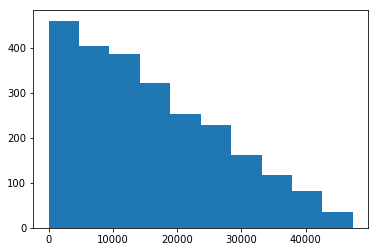

In [8]:
print(len(list(set(BadTrees))))
plt.hist((list(set(BadTrees))))
plt.show()

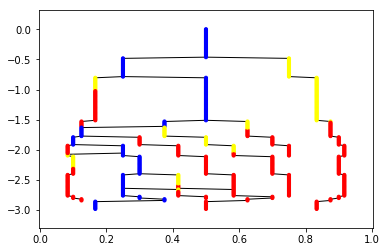

In [9]:
%matplotlib inline
Redshift = (1/SF) -1
#Sets Attributes of root
nx.set_node_attributes(MergerTree, 'color', {MPH: 'blue'})

#makes color mapping for plotting hte nodes
nodes = MergerTree.nodes()
colors = [MergerTree.node[n]['color'] for n in nodes]

#makes the graph area
fig = plt.figure()
fig.set_axes
#plt.ylim(Redshift,0)
#plt.xlim(1, -3)
ax = fig.add_axes()

#Makes the positioning of the nodes
pos = hierarchy_pos(MergerTree, MPH, height = 3) #2nd input is the root (MP at z = 0)
#pos = MakePosition(MergerTree, MPH, MPB, MPH, 0)
#'draws' the graph
nx.draw_networkx(MergerTree, pos = pos, nodelist = nodes, node_color = colors, with_labels = False, node_size = 10, ax = ax)

In [10]:
Masses = []
for i in KeepList:
    Masses.append(i[1])
Masses = np.array(Masses)
print(np.log10(np.max(Masses)))

14.5422027824


In [11]:
print(SortedKeepList)

[['Tree2812818649.dat', 67875000000.0], ['Tree2812816630.dat', 67875000000.0], ['Tree2809266137.dat', 67875000000.0], ['Tree2812679563.dat', 67875000000.0], ['Tree2812843036.dat', 67875000000.0], ['Tree2811228827.dat', 67875000000.0], ['Tree2812794253.dat', 67875000000.0], ['Tree2809460798.dat', 67875000000.0], ['Tree2810908500.dat', 67875000000.0], ['Tree2809460291.dat', 67875000000.0], ['Tree2811254878.dat', 67875000000.0], ['Tree2812411395.dat', 67875000000.0], ['Tree2811058462.dat', 67875000000.0], ['Tree2812386103.dat', 67875000000.0], ['Tree2812790727.dat', 67875000000.0], ['Tree2812648831.dat', 67875000000.0], ['Tree2810832525.dat', 67875000000.0], ['Tree2810857177.dat', 67875000000.0], ['Tree2814003288.dat', 67875000000.0], ['Tree2811228856.dat', 67875000000.0], ['Tree2811256145.dat', 67875000000.0], ['Tree2811266648.dat', 67875000000.0], ['Tree2810845478.dat', 67875000000.0], ['Tree2812636824.dat', 67875000000.0], ['Tree2812382445.dat', 67875000000.0], ['Tree2809511790.dat', 6

%%bash

cd /data/B-P50Mpc/Processed

find . -name "*.dat" -print0 | xargs -0 rm

cd /data/B-P50Mpc/Above12

find . -name "*.dat" -print0 | xargs -0 rm

cd /data/B-P50Mpc/Above12/RedshiftCut/SEMunbinned

find . -name "*.dat" -print0 | xargs -0 rm